# Chip RISC V CPU: Physical tape out in a Jupyter notebook on ExamScale Cluster

Motivated by difficulty experiences in IC Design about 18  and 8 years ago, this note will save time and resource for **next generation Electronics Engineering and Computer Science** who are **interested in digital and mixed-signal integrate circuit**. If I could persuade you to rethink about Open Source tools for real-world digital/analog chip design and tape out for manufacture **efabless University program** efabless.com

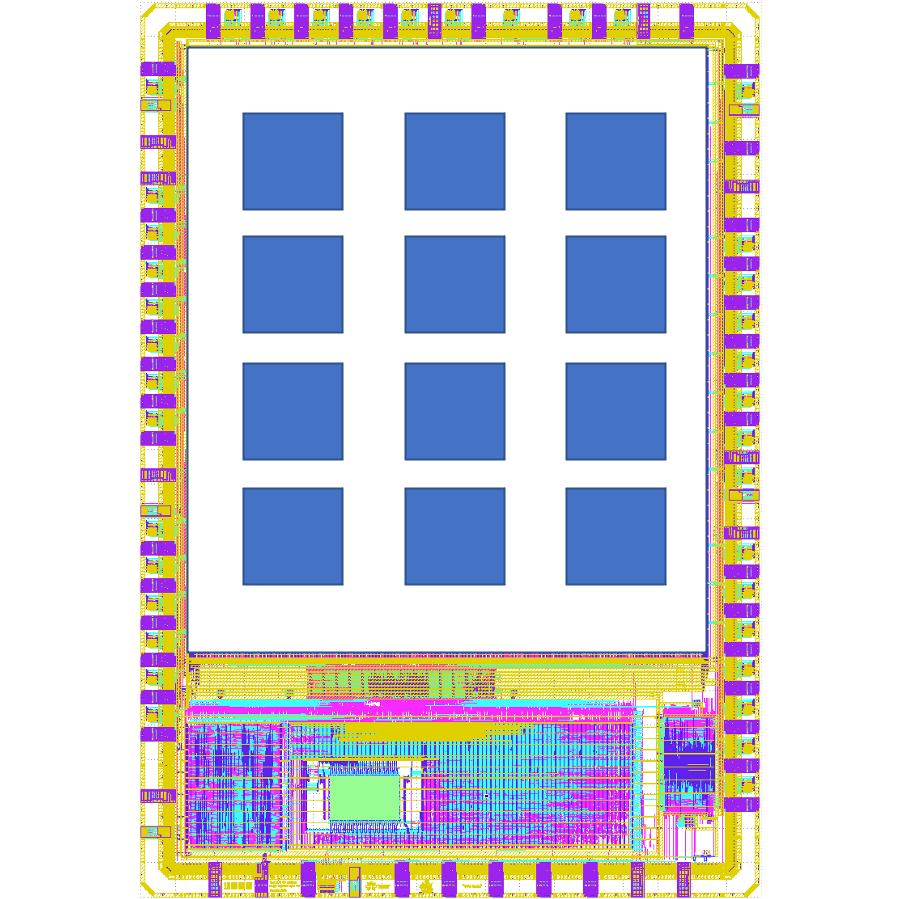

In [5]:
# $![image.png](attachment:460a7c8f-901b-46a3-bf6d-25d5c1d8e9eb.png)
from IPython import display
display.Image("https://efabless.com/lib_CUsguFEVafmoKCKW/klx999yu9pesnun9.png")


Figure: Multi-project-wafer at efabless.com

It might be four breakthroughs in open source IC design and tape out chip layout to fabricate at chip manufacture.

-	OpenROAD Project:: Open source tools for complete and complex IC design processes. Compare to commercial tools, OpenLane based on OpenROAD can be applied to Automatic IC design flow which can reduce human interaction for less than 24 hours turn around time from Register Transfer Lever (RTL) to Layout tape process, GDS file.[1]

-	Open Sky130 PDK, SkyWater Open Source PDK is a collaboration between Google and SkyWater Technology Foundry to provide a fully open source Process Design Kit and related resources, which can be used to create manufacturable designs at SkyWater’s facility. [2]

-	Muti-project-wafer or MPW, began 1981 Metal Oxide Silicon Implementation Service), established by DARPA as a technical and human infrastructure for VLSI[3], many university course the course produced ‘multi-university, multi-project chip-design demonstration had been ended.  New for opportunity for Open chip for university project has been started by Efabless with Skywater and Google partners. [4]

-	High Performance Computing for CAD/CAM as we create chip layout rendering is a time-consuming task and sometimes lead to failure of project delivery. With GPU, it is not only speed we will achieve, but flexibility in programming is also countless. [5]

This post will demonstration how to work out on IC design flow from  RTL to GDS tape out as shown in following diagram.

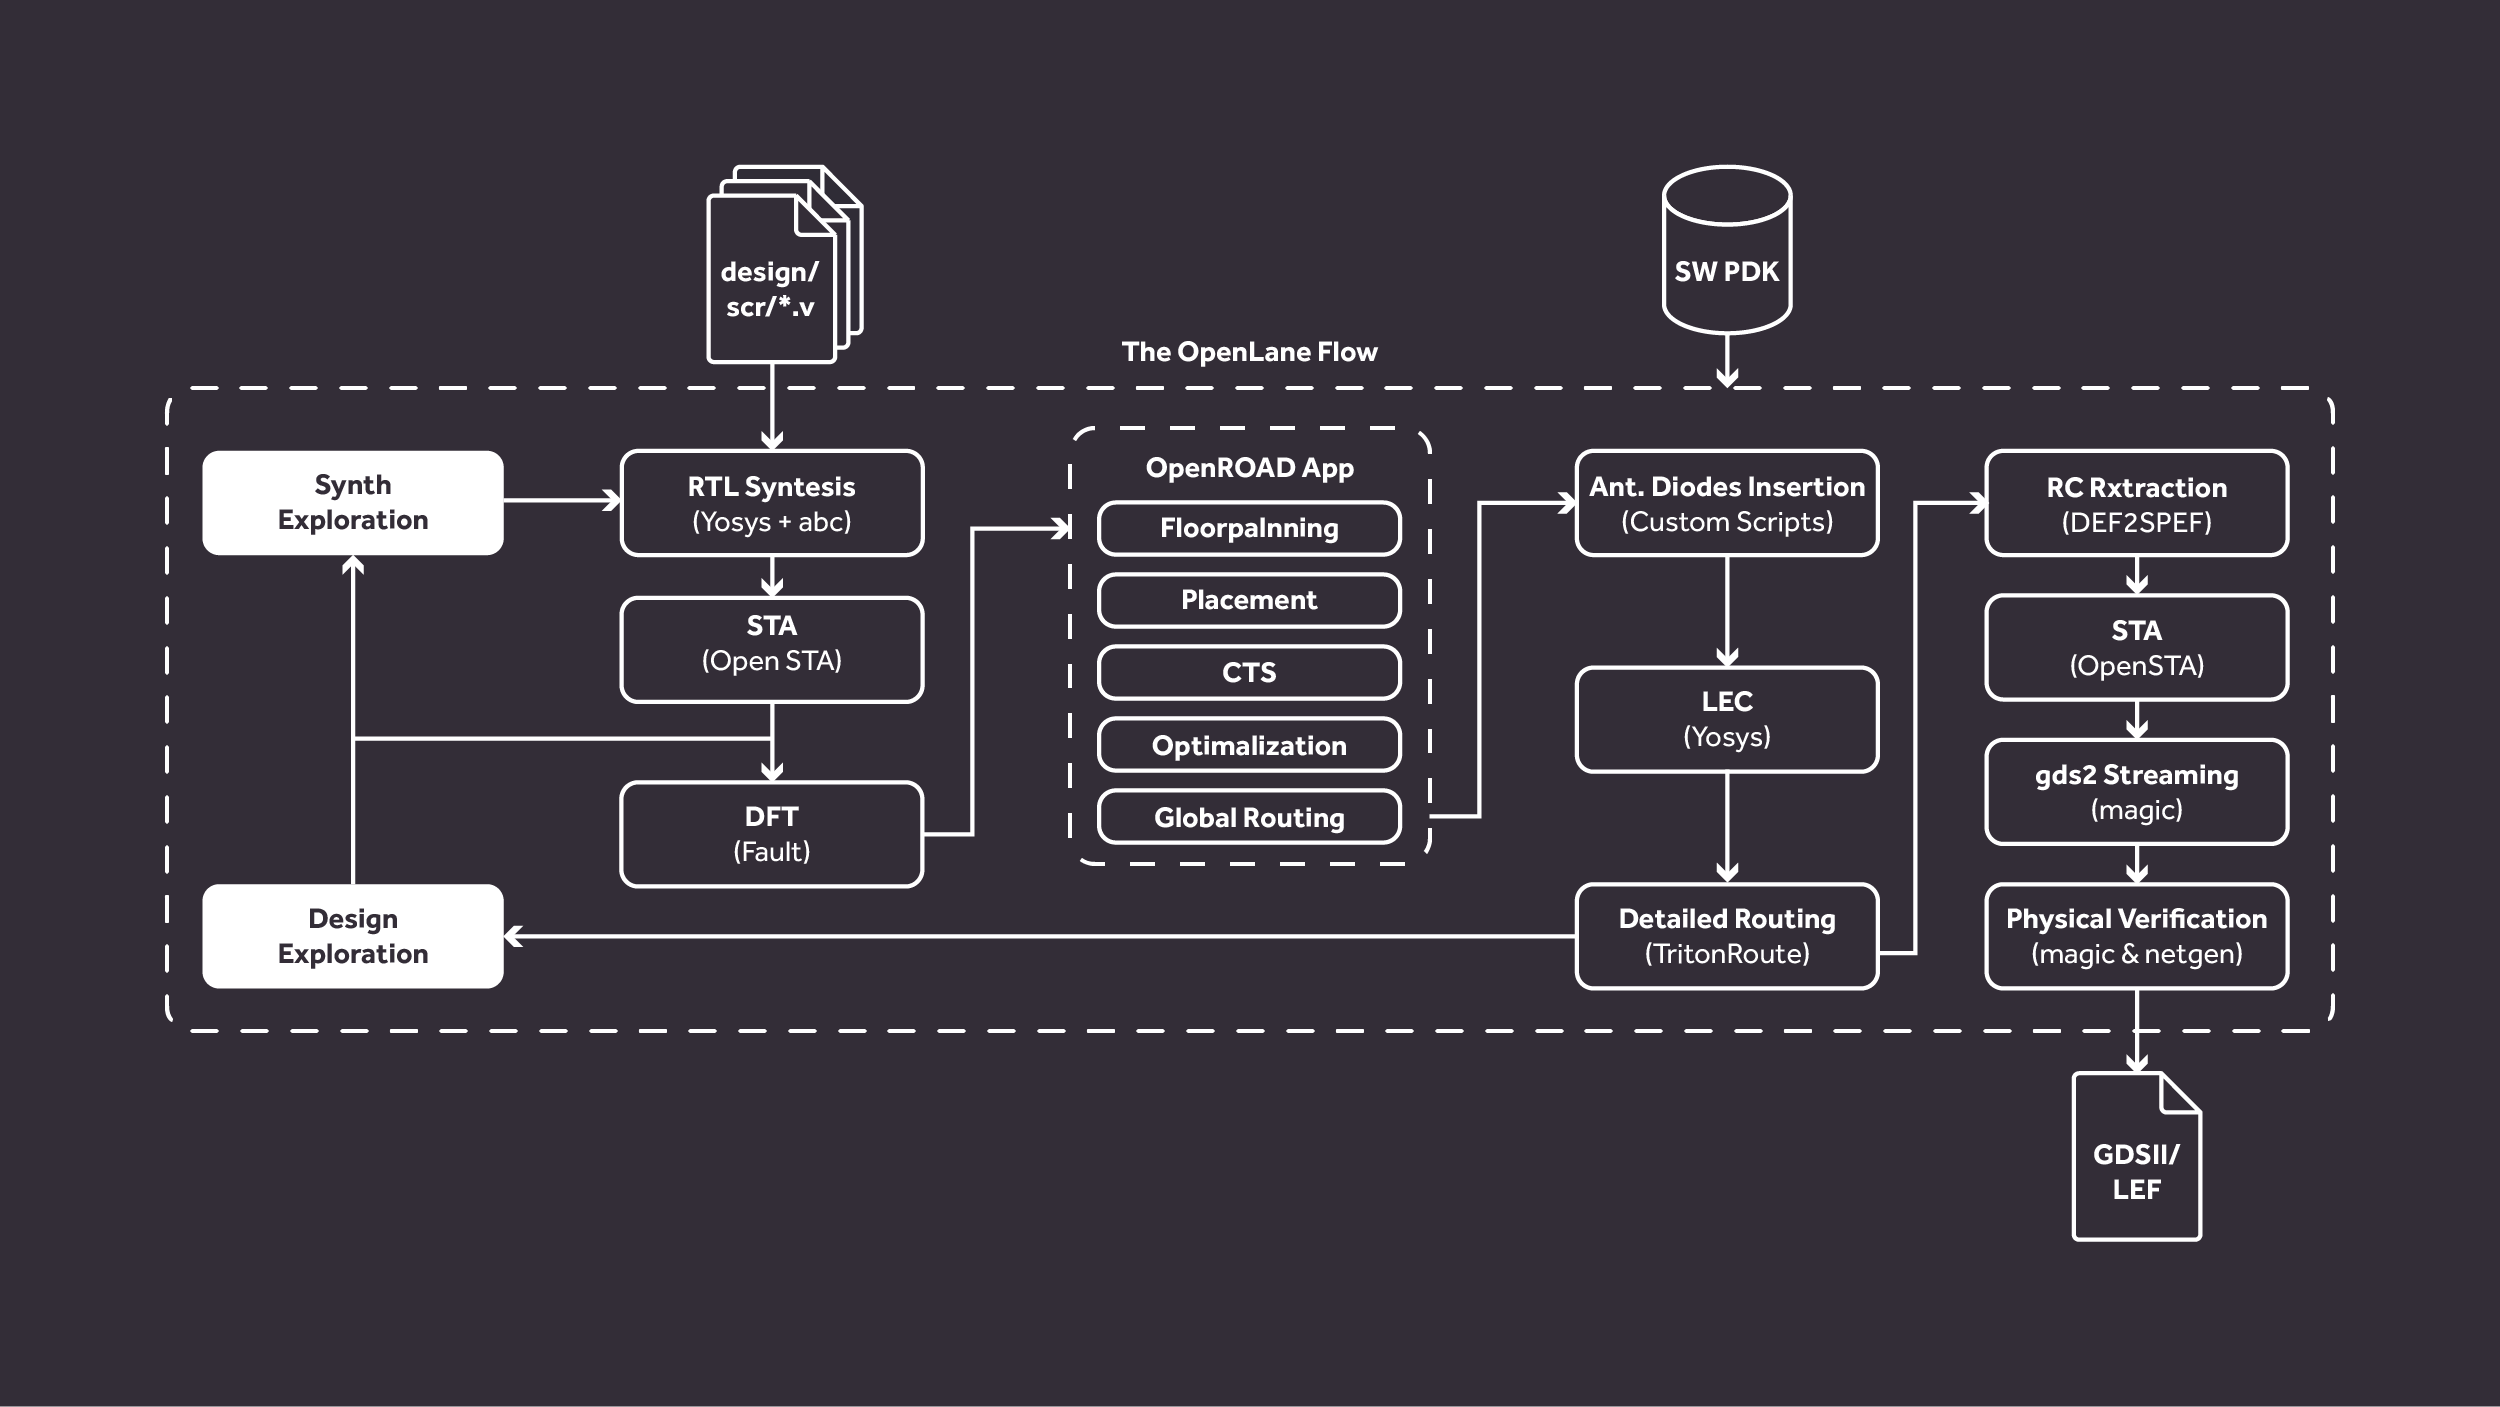

In [6]:
from IPython import display
display.Image("https://antmicro.com/blog/images/openlane-flow.png")

Source[Antmicro · Improving the OpenLane ASIC build flow with open source SystemVerilog support]

We will demonstrate how to generate physical IC layout design from Verilog RTL for RISC V CPU, named as Picorv32a[6]

## Step 0: Prepare Environment and Download EDA

Before start jupyter notebook, on any head node, login node

$conda create --name chipREal

$conda activate chipReal

$ mkdir chip_design_tape_out

$ cd chip_design_tape_out

$ git clone --depth=1 https://github.com/The-OpenROAD-Project/OpenLane

In [ ]:
%%writefile environment.yml
channels:
  - litex-hub
  - conda-forge
dependencies:
  - open_pdks.sky130A
  - magic
  - ngspice-lib
  - gdstk
  - python
  - pip
  - openroad
  - netgen
  - yosys
  - tcllib
  - pyyaml
  - click
  - pip:
    - cairosvg
    - pyspice


In bash shell not jupyter notebook
Update conda environment:

$ conda env update --file environment.yml


## Step 1: Prepare Makefile and env.py, from Docker to Singularity

On ExScale we cannot use Docker  so we need to chagne defualt configuration to Singularity configuration in   Makefile.

In [ ]:
%%writefile OpenLane/Makefile
# Copyright 2020-2022 Efabless Corporation
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
PYTHON_BIN ?= python3

OPENLANE_DIR ?= $(shell pwd)

DOCKER_OPTIONS = $(shell $(PYTHON_BIN) ./env.py docker-config)

DOCKER_ARCH ?= $(shell $(PYTHON_BIN) ./docker/current_platform.py)

# Allow Configuring Memory Limits
ifneq (,$(DOCKER_SWAP)) # Set to -1 for unlimited
DOCKER_OPTIONS += --memory-swap=$(DOCKER_SWAP)
endif
ifneq (,$(DOCKER_MEMORY))
DOCKER_OPTIONS += --memory=$(DOCKER_MEMORY)
# To verify: cat /sys/fs/cgroup/memory/memory.limit_in_bytes inside the container
endif

# Allow using GUIs
UNAME_S = $(shell uname -s)
ifeq ($(UNAME_S),Linux)
DOCKER_OPTIONS += --env DISPLAY=$(DISPLAY) -B /tmp/.X11-unix:/tmp/.X11-unix -B $(HOME)/.Xauthority:/.Xauthority 
  ifneq ("$(wildcard $(HOME)/.openroad)","")
    DOCKER_OPTIONS += -B $(HOME)/.openroad:/.openroad
  endif
endif

THREADS ?= 1

ifneq (,$(ROUTING_CORES))
DOCKER_OPTIONS += --env ROUTING_CORES=$(ROUTING_CORES)
endif

include ./dependencies/image_name.mk

TEST_DESIGN ?= spm
DESIGN_LIST ?= spm
QUICK_RUN_DESIGN ?= spm
BENCHMARK ?= regression_results/benchmark_results/SW_HD.csv
REGRESSION_TAG ?= TEST_SW_HD
FASTEST_TEST_SET_TAG ?= FASTEST_TEST_SET
EXTENDED_TEST_SET_TAG ?= EXTENDED_TEST_SET
PRINT_REM_DESIGNS_TIME ?= 0

SKYWATER_COMMIT ?= $(shell $(PYTHON_BIN) ./dependencies/tool.py sky130 -f commit)
OPEN_PDKS_COMMIT ?= $(shell $(PYTHON_BIN) ./dependencies/tool.py open_pdks -f commit)

export PDK_ROOT ?= ./pdks
export PDK_ROOT := $(shell $(PYTHON_BIN) -c "import os; print(os.path.realpath('$(PDK_ROOT)'), end='')")
PDK_OPTS = -B $(PDK_ROOT):$(PDK_ROOT) --env PDK_ROOT=$(PDK_ROOT)

export PDK ?= sky130A


PDK_OPTS += --env PDK=$(PDK)

ifneq ($(STD_CELL_LIBRARY),)
export STD_CELL_LIBRARY ?= sky130_fd_sc_hd
PDK_OPTS += --env STD_CELL_LIBRARY=$(STD_CELL_LIBRARY)
endif

# ./designs is mounted over ./install so env.tcl is not found inside the Docker
# container if the user had previously installed it.
ENV_START = singularity exec --nv\
	-B $(OPENLANE_DIR):/openlane\
	-B $(OPENLANE_DIR)/designs:/openlane/install\
	$(PDK_OPTS)\
	$(STD_CELL_OPTS)\
	$(DOCKER_OPTIONS)

#ENV_COMMAND = $(ENV_START) $(OPENLANE_IMAGE_NAME)-$(DOCKER_ARCH)
ENV_COMMAND = $(ENV_START) openlane.sif 

ENV_RUN = singularity shell --nv\
        -B $(OPENLANE_DIR):/openlane\
        -B $(OPENLANE_DIR)/designs:/openlane/install\
        $(PDK_OPTS)\
        $(STD_CELL_OPTS)\
        $(DOCKER_OPTIONS)
ENV_COMMAND_RUN = $(ENV_RUN) openlane.sif

.DEFAULT_GOAL := all

.PHONY: all
all: get-openlane pdk

.PHONY: openlane
openlane: venv/created
	@PYTHON_BIN=$(PWD)/venv/bin/$(PYTHON_BIN) $(MAKE) -C docker openlane

.PHONY: openlane-and-push-tools
openlane-and-push-tools: venv/created
	@PYTHON_BIN=$(PWD)/venv/bin/$(PYTHON_BIN) BUILD_IF_CANT_PULL=1 BUILD_IF_CANT_PULL_THEN_PUSH=1 $(MAKE) -C docker openlane

pull-openlane:
	@singularity pull openlane.sif "docker://$(OPENLANE_IMAGE_NAME)"

get-openlane:
	@$(MAKE) pull-openlane || $(MAKE) openlane

.PHONY: mount
mount:
	cd $(OPENLANE_DIR) && \
	$(ENV_COMMAND_RUN)
        	

.PHONY: pdk
pdk: venv/created
	./venv/bin/$(PYTHON_BIN) -m pip install --upgrade --no-cache-dir volare
	./venv/bin/volare enable

.PHONY: survey
survey:
	$(PYTHON_BIN) ./env.py issue-survey


.PHONY: lint
lint: venv/created
	./venv/bin/black --check .
	./venv/bin/flake8 .

.PHONY: start-build-env
start-build-env: venv/created
	bash -c "bash --rcfile <(cat ~/.bashrc ./venv/bin/activate)"

venv: venv/created
venv/created: ./requirements.txt ./requirements_dev.txt ./requirements_lint.txt ./dependencies/python/precompile_time.txt ./dependencies/python/run_time.txt 
	rm -rf ./venv
	$(PYTHON_BIN) -m venv ./venv
	./venv/bin/$(PYTHON_BIN) -m pip install --upgrade --no-cache-dir pip
	./venv/bin/$(PYTHON_BIN) -m pip install --upgrade --no-cache-dir -r ./requirements_dev.txt
	touch $@

DLTAG=custom_design_List
.PHONY: test_design_list fastest_test_set extended_test_set
fastest_test_set: DESIGN_LIST=$(shell cat ./.github/test_sets/fastest_test_set)
fastest_test_set: DLTAG=$(FASTEST_TEST_SET_TAG)
fastest_test_set: test_design_list
extended_test_set: DESIGN_LIST=$(shell cat ./.github/test_sets/extended_test_set)
extended_test_set: DLTAG=$(EXTENDED_TEST_SET_TAG)
extended_test_set: test_design_list
test_design_list:
	cd $(OPENLANE_DIR) && \
		$(ENV_COMMAND) sh -c "\
			python3 run_designs.py\
			--tag $(DLTAG)\
			--threads $(THREADS)\
			--print_rem $(PRINT_REM_DESIGNS_TIME)\
			--benchmark $(BENCHMARK)\
			$(DESIGN_LIST)\
		"
# -u is needed, as the python buffers the stdout, so no output is generated
run_issue_regression:
	cd $(OPENLANE_DIR) && \
		$(ENV_COMMAND) sh -c "\
			python3 -um tests run $(ISSUE_REGRESSION_DESIGN)"

issue_regression_all:
	cd $(OPENLANE_DIR) && \
		$(ENV_COMMAND) sh -c "\
			python3 -um tests run_all"

.PHONY: test
test:
	cd $(OPENLANE_DIR) && \
		$(ENV_COMMAND) sh -c "./flow.tcl -design $(TEST_DESIGN) -tag openlane_test -overwrite"
	@[ -f $(OPENLANE_DIR)/designs/$(TEST_DESIGN)/runs/openlane_test/results/signoff/$(TEST_DESIGN).gds ] && \
		echo "Basic test passed" || \
		echo "Basic test failed"

.PHONY: quick_run
quick_run:
	cd $(OPENLANE_DIR) && \
		$(ENV_COMMAND) sh -c "./flow.tcl -design $(QUICK_RUN_DESIGN)"

.PHONY: veryclean clean_runs clean_results
veryclean:
	@git clean -fdX

clean_runs:
	@rm -rf ./designs/*/runs && rm -rf ./_build/it_tc_logs && echo "Runs cleaned successfully." || echo "Failed to delete runs."
	@rm -rf ./tests/*/runs && echo "Test runs cleaned successfully." || echo "Failed to delete test runs."

clean_results:
	@{ find regression_results -mindepth 1 -maxdepth 1 -type d | grep -v benchmark | xargs rm -rf ; } && echo "Results cleaned successfully." || echo "Failed to delete results."


### Correct Docker Environment to Singularity
By modified **env.py** in OpenLane

In [ ]:
%%writefile OpenLane/env.py
#!/usr/bin/env python3

# Copyright 2021 Efabless Corporation
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Note to maintainers/contributors:
#
# Ensure you don't use f strings, non-comment type hints or any other features
# that wouldn't work on Python 3.3
#
# Inevitably, some people won't read the Readme and then complain that the issue
# survey doesn't work on their older Python versions. As long as it's compatible
# with Python 3.3, this script will tell them that their python version is
# below the minimum supported.

import io
import os
import sys
import getpass
import textwrap
import subprocess
from os.path import abspath, dirname

openlane_dir = dirname(abspath(__file__))
is_root = os.geteuid() == 0

# Commands
def tool_list():
    from dependencies.tool import Tool

    tools = Tool.from_metadata_yaml(open("./dependencies/tool_metadata.yml").read())
    for tool in tools.values():
        print("%s %s" % (tool.name, tool.version_string))


def local_install():
    from dependencies.installer import Installer

    installer = Installer()
    installer.run()


def docker_config():
    from dependencies.env_info import ContainerInfo

    cinfo = ContainerInfo.get()
    if cinfo is None:
        raise Exception("No container engine found.")
'''
    if cinfo.engine == "docker":
        if cinfo.rootless:
            print("-u 0", end="")
        else:
            uid = (
                subprocess.check_output(["id", "-u", getpass.getuser()])
                .decode("utf8")
                .strip()
            )
            gid = (
                subprocess.check_output(["id", "-g", getpass.getuser()])
                .decode("utf8")
                .strip()
            )
            print("--user %s:%s" % (uid, gid), end="")

'''
def issue_survey():
    sys.path.append(os.path.dirname(__file__))
    from dependencies.env_info import OSInfo
    from dependencies.version import parse as vp

    alerts = open(os.devnull, "w")

    final_report = ""

    os_info = OSInfo.get()
    final_report += textwrap.dedent(
        """\
        Kernel: %s v%s
        """
        % (os_info.kernel, os_info.kernel_version)
    )

    if os_info.distro is not None:
        final_report += textwrap.dedent(
            """\
            Distribution: %s %s
            """
            % (os_info.distro, (os_info.distro_version or ""))
        )

    python_version = vp(os_info.python_version)
    minimum_python_version = vp("3.6")
    python_message = "OK"
    python_ok = True
    if python_version < minimum_python_version:
        python_message = "BELOW MINIMUM: UPDATE PYTHON"
        python_ok = False

    final_report += textwrap.dedent(
        """\
        Python: v%s (%s)
        """
        % (python_version, python_message)
    )

    if os_info.container_info is not None:
        container_version = vp(os_info.container_info.version)

        container_message = "UNSUPPORTED"
        if "docker" in os_info.container_info.engine:
            container_message = "OK"
            minimum_docker_version = vp("19.03.12")
            if container_version < minimum_docker_version:
                container_message = "BELOW MINIMUM: UPDATE DOCKER"

        final_report += textwrap.dedent(
            """\
            Container Engine: %s v%s (%s)
            """
            % (os_info.container_info.engine, container_version, container_message)
        )
    elif os.path.exists(
        "/git_version"
    ):  # i.e. if running inside the OpenLane container
        print("Alert: Running in container.", file=alerts)
        final_report = (
            textwrap.dedent(
                """\
                WARNING: issue-survey appears to be running inside the OpenLane
                container.

                This makes it difficult to rule out issues with your
                environment.

                Unless instructed specifically to do so, please run this command
                outside the OpenLane container.
                ---\n
                """
            )
            + final_report
        )
    else:
        alert = (
            "Critical Alert: No Docker or Docker-compatible container engine was found."
        )
        final_report += "%s\n" % alert
        print(alert, file=alerts)

    if python_ok:
        from dependencies.get_tag import get_tag

        final_report += textwrap.dedent(
            """\
            OpenLane Git Version: %s
            """
            % get_tag()
        )

    pip_ok = True
    try:
        import pip  # noqa F401
    except ImportError:
        pip_ok = False

    alert = (
        "pip: " + "INSTALLED"
        if pip_ok
        else "NOT FOUND: Please install pip using your operating system's package manager."
    )

    final_report += "%s\n" % alert
    print(alert, file=alerts)

    if pip_ok:
        venv_ok = True
        try:
            import venv  # noqa F401
        except ImportError:
            venv_ok = False

        alert = (
            "python-venv: " + "INSTALLED"
            if venv_ok
            else "NOT FOUND: Please install python-venv using your operating system's package manager."
        )
        final_report += "%s\n" % alert
        print(alert, file=alerts)

    if python_ok:
        from dependencies.verify_versions import verify_versions

        with io.StringIO() as f:
            status = "OK"
            try:
                mismatches = verify_versions(
                    no_tools=True, report_file=f, pdk=os.getenv("PDK") or "sky130A"
                )
                if mismatches:
                    status = "MISMATCH"
            except Exception:
                status = "FAILED"
                f.write("Failed to verify sky130A.")
                f.write("\n")
            final_report += "---\nPDK Version Verification Status: %s\n%s" % (
                status,
                f.getvalue(),
            )

        try:
            git_log = subprocess.check_output(
                [
                    "git",
                    "log",
                    r"--format=%h %cI %s - %an - %gs (%D)",
                    "-n",
                    "3",
                ]
            ).decode("utf8")

            final_report += "---\nGit Log (Last 3 Commits)\n\n" + git_log

            remotes = subprocess.check_output(["git", "remote", "-v", "show"]).decode(
                "utf8"
            )

            final_report += "---\nGit Remotes\n\n" + remotes
        except subprocess.CalledProcessError:
            pass

    print(final_report, end="")


# Entry Point
def main():
    args = sys.argv[1:]
    commands = {
        "tool-list": tool_list,
        "local-install": local_install,
        "docker-config": docker_config,
        "issue-survey": issue_survey,
    }

    if len(args) < 1 or args[0] not in commands.keys():
        print(
            "Usage: %s (%s)" % (sys.argv[0], "|".join(commands.keys())), file=sys.stderr
        )
        sys.exit(os.EX_USAGE)

    commands[args[0]]()


if __name__ == "__main__":
    main()


## Step 2. Download the Docker Image and Install sky130 PDK
Download the Docker image of OpenLane and install sky130 PDK:


In [1]:
!cd OpenLane && make

make[1]: Entering directory '/home/snit.san/chip_design_tape_out/OpenLane'
INFO:    Using cached SIF image
make[1]: Leaving directory '/home/snit.san/chip_design_tape_out/OpenLane'
./venv/bin/python3 -m pip install --upgrade --no-cache-dir volare
./venv/bin/volare enable
[15:06:38] Found version de752ec0ba4da0ecb1fbcd309eeec4993d88f5bc  ]8;id=176405;file:///home/snit.san/chip_design_tape_out/OpenLane/venv/lib/python3.8/site-packages/volare/common.py\common.py]8;;\:]8;id=961025;file:///home/snit.san/chip_design_tape_out/OpenLane/venv/lib/python3.8/site-packages/volare/common.py#226\226]8;;\
           in ./dependencies/tool_metadata.yml.                                 
⠋ Enabling version de752ec0ba4da0ecb1fbcd309eeec4993d88f5bc…
PDK version de752ec0ba4da0ecb1fbcd309eeec4993d88f5bc enabled.


## Step 3: Validating your OpenLane Installation

Test the installed PDK and OpenLane:

In [2]:
!cd OpenLane && make test

cd /home/snit.san/chip_design_tape_out/OpenLane && \
	singularity exec --nv -B /home/snit.san/chip_design_tape_out/OpenLane:/openlane -B /home/snit.san/chip_design_tape_out/OpenLane/designs:/openlane/install -B /home/snit.san/chip_design_tape_out/OpenLane/pdks:/home/snit.san/chip_design_tape_out/OpenLane/pdks --env PDK_ROOT=/home/snit.san/chip_design_tape_out/OpenLane/pdks --env PDK=sky130A   --env DISPLAY=localhost:11.0 -B /tmp/.X11-unix:/tmp/.X11-unix -B /home/snit.san/.Xauthority:/.Xauthority  openlane.sif  sh -c "./flow.tcl -design spm -tag openlane_test -overwrite"
OpenLane 32da932761213af689f10088d671e1e3dc38f273
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[INFO]: Using configuration in 'designs/spm/config.json'...
[INFO]: PDK Root: /home/snit.san/chip_design_tape_out/OpenLane/pdks
[INFO]: Process Design Kit: sky130A
[INFO]: Standard Cell Library: sky130_fd_sc_hd

Sucessful test looks like this:
Basic test passed


# Step 4: Run IC Physical Layout Flow

In [ ]:
# Enter a Singularity session:
$ cd OpenLane && make mount


In [ ]:
# inside container shell
Singularity> cd /openlane
Singularity> ./flow.tcl -design picorv32a

## Step 5: View RISCV CPU tape out Layout

In [ ]:
# still insice container shell
Singularity> klayout  

open browse of klayout folder to  context path of the result dependence on your system. /designs/picorv32a/runs/RUN_2022.10.13_04.40.06/results/final/gds/picorv32.gdsead215ffd805.png

In [ ]:
# inside contain if you want to end of synthesis
Singularity> exit

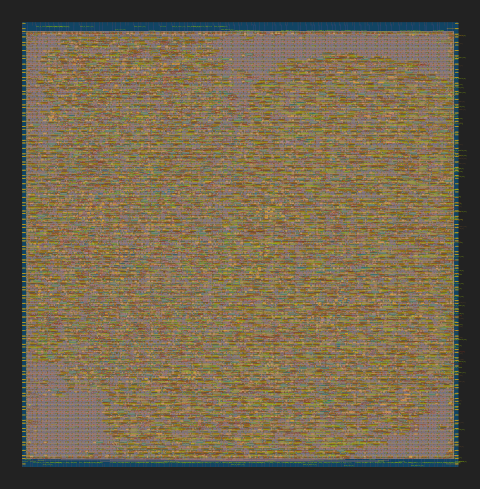

In [5]:
import gdstk
import cairosvg
from IPython.display import Image

library = gdstk.read_gds('/home/snit.san/chip_design_tape_out/OpenLane/designs/picorv32a/runs/RUN_2022.10.14_10.45.33/results/final/gds/picorv32.gds')
top_cells = library.top_level()
top_cells[0].write_svg('picorv32.svg')
cairosvg.svg2png(url='picorv32.svg', write_to='picorv32.png', scale=0.08)
Image('picorv32.png')

Singularity image is shared at */shared/software/singularity/images/openlane.sif*. With given container image you can modify "Makefile" to mount software for your physcial desing.

If you want to start design and simulation then it is short introduction to __Verilator__ [7-8]

## References:
1. OpenROAD project 

    https://github.com/The-OpenROAD-Project

2. Open Source Process Design Kit Skywave 130nm process

    [https://github.com/google/skywater-pdk]
 
3. MPW 

    https://en.wikipedia.org/wiki/Multi-project_wafer_service

4. MPW university projgram 

    http://efabless.com

5. High-performance computing (HPC) for manufacturing

    https://learn.microsoft.com/en-us/azure/architecture/industries/manufacturing/compute-manufacturing-overview
    
6. Picorv32

    https://github.com/YosysHQ/picorv32
    
7. Verilog Primer
   
   https://inst.eecs.berkeley.edu/~eecs151/fa21/files/verilog/Verilog_Primer_Slides.pdf


9. Veriator RTL somulation

    https://verilator.org/guide/latest/install.html
   
10. Drawing Stick Diagrams

    https://www.southampton.ac.uk/~bim/notes/cad/guides/sticks.html